In [ ]:
!pip install wandb

### Import libraries

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import wandb
from wandb.keras import WandbCallback

### Wandb configuration

In [3]:
wandb.init(project="computer-accessories-recognition", entity="benyaminzojaji")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
config = wandb.config
config.learning_rate = 0.001

### Dataset

In [6]:
dataset_path = '/content/drive/MyDrive/computer accessories'
width = height = 224

idg = ImageDataGenerator(
    rescale = 1./255,

    # Augmentation
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 45,
    brightness_range = (0.9, -0.1),
    validation_split = 0.1
)

train_data = idg.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    subset='training'
)

val_data = idg.flow_from_directory(
    dataset_path,
    target_size=(width, height),
    class_mode='categorical',
    subset='validation'
)

Found 741 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


### Model

In [12]:
model = tf.keras.models.Sequential([
                                    Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
                                    Conv2D(32, (3, 3), activation='relu'),
                                    MaxPool2D(),
                                    Conv2D(32, (3, 3), activation='relu'),
                                    Conv2D(32, (3, 3), activation='relu'),
                                    MaxPool2D(),
                                    Conv2D(32, (3, 3), activation='relu'),
                                    Conv2D(32, (3, 3), activation='relu'),
                                    MaxPool2D(),

                                    Flatten(),
                                    Dense(256, activation='relu'),
                                    Dense(4, activation='softmax'),
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(config.learning_rate),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [16]:
model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[WandbCallback()])

Epoch 1/20
24/24 [==============================] - 26s 1s/step - loss: 0.9373 - accuracy: 0.6140 - val_loss: 0.9725 - val_accuracy: 0.5375 - _timestamp: 1647075717.0000 - _runtime: 2165.0000
Epoch 2/20
24/24 [==============================] - 25s 1s/step - loss: 0.9042 - accuracy: 0.6073 - val_loss: 1.0118 - val_accuracy: 0.6250 - _timestamp: 1647075742.0000 - _runtime: 2190.0000
Epoch 3/20
24/24 [==============================] - 25s 1s/step - loss: 0.8096 - accuracy: 0.6626 - val_loss: 1.1028 - val_accuracy: 0.6000 - _timestamp: 1647075766.0000 - _runtime: 2214.0000
Epoch 4/20
24/24 [==============================] - 25s 1s/step - loss: 0.8640 - accuracy: 0.6572 - val_loss: 1.1347 - val_accuracy: 0.5750 - _timestamp: 1647075792.0000 - _runtime: 2240.0000
Epoch 5/20
24/24 [==============================] - 25s 1s/step - loss: 0.8480 - accuracy: 0.6343 - val_loss: 1.0344 - val_accuracy: 0.5875 - _timestamp: 1647075817.0000 - _runtime: 2265.0000
Epoch 6/20
24/24 [======================

In [17]:
model.save('cnn-deviceRecognizer.h5')

In [19]:
# ImageDataGenerator has no test split so i'll do this instead ...
idg = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0
)

In [20]:
test_path = '/content/drive/MyDrive/data-accessories/test'
width = height = 224
test_data = idg.flow_from_directory(
    test_path,
    target_size=(width, height),
    class_mode='categorical',
    subset='training'
)

Found 101 images belonging to 4 classes.


In [21]:
model.evaluate(test_data)

4/4 [==============================] - 2s 307ms/step - loss: 1.1442 - accuracy: 0.7723


[1.1441563367843628, 0.7722772359848022]

In [27]:
Y_pred = []

for path in test_data.filepaths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (width, height))
    img = img / 255
    img = img.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(img)))

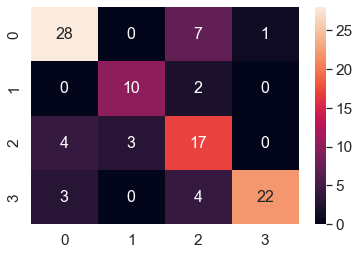

In [33]:
conf_mat = confusion_matrix(test_data.classes, Y_pred)
sn.set(font_scale=1.4) # for label size
sn.heatmap(conf_mat, annot=True, annot_kws={"size": 16})
plt.show()